In [1]:
#Use the "Space" environemnt 
from osgeo import gdal, osr
import numpy as np
import json
import sys
import geoio  
import cv2 
import os 
import time 
from numba import njit
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

In [ ]:
#1
#from scratch (prefered): create bin maps with alternative names from "C:\Users\sbgass\Pictures\AOI_5_Khartoum\AOI_5_Khartoum_Train\RGB_JPEGs" geojson/buildings and RGB-Pansharpen
#OR use alt_name bin maps in "C:\Users\sbgass\Pictures\AOI_5_Khartoum\AOI_5_Khartoum_Train\masks with alt names"

#2
#one pass- label points as interior, border, exterior by 8 connectedness 
#0,1,2

#3
#run distance function algorithm 
#OR (prefered) run alternative distance function algorithm 
#OR also consider sqrt distance maps 

#4
#normalize and save distance map in new directory like "C:\Users\sbgass\Pictures\AOI_5_Khartoum\AOI_5_Khartoum_Train\dist_maps\"

In [2]:
@njit
def check_border(img,point):
    #check the eight directions. If this point has a 0 in any of those 8 directions, return true 
    y, x = point 
    width,height = img.shape
    deltas = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)] #all eight directions
    #find connecting components 
    for dy, dx in deltas: 
        row = y + dy
        col = x + dx 
        if (row >= 0 and row < height) and (col >=0 and col < width): #if valid coordinate 
            if img[row,col] == 0:
                return img[y,x] > 0 #return true if this point is not background itself 
    return False 

In [3]:
@njit
def seg_borders(img):
    #returns np array: background = 0, border=1, interior = 2 
    #input image is binary 0 or 255 numpy array 

    width, height = img.shape

    for y in range(height):
        for x in range(width): 
            #check whether this is background or foreground 
            if img[y,x] > 0:
                #check if this is a border point
                if check_border(img,(y,x)):
                    img[y,x] = 1 #border points are labeled as 1's 
                else:
                    img[y,x] = 2 #interior points are labeled as 2's

    return img

In [ ]:
"""
@njit
def get_raster_distance(img,point):
    #do a signle pass through the image to get the raster distance to the closest border point (pixelval==1)
    
    og_y, og_x = point
    width,height=img.shape 
    min_dist = (width**2+height**2)**0.5 #maximum distance is the diagnol of the img 
    for y in range(height):
        for x in range(width): 
            if img[y,x] == 1:
                dist = max(abs(og_y-y),abs(og_x-x))
                if dist < min_dist:
                    min_dist = dist 
    return min_dist"""

In [4]:
@njit
def get_radial_distance(img,point):
    #do a single pass through the image to get the euclidean distance to the closest border point (pixelval==1)
    og_y, og_x = point
    width,height=img.shape 
    min_dist = (width**2+height**2)**0.5 #maximum distance is the diagnol of the img 
    for y in range(height):
        for x in range(width): 
            if img[y,x] == 1:
                dist = ((og_x-x)**2+(og_y-y)**2)**0.5
                if dist < min_dist:
                    min_dist = dist 
    return min_dist

In [5]:
@njit
def dist_map(img):
    #find the pixel distance to the nearest border point (pixelval==1)
    #input is a segmented building map using sef_borders()
    
    img = img.astype(np.float64)
    width, height = img.shape
    
    #what if there are no annotations in the map: 
    #can't use all() with njit, is it worth doing a single double for loop to check and make sure... 

    for y in range(height):
        for x in range(width): 
            if img[y,x] != 1: #if this is not a border point 
                dist = get_radial_distance(img,(y,x))
                if img[y,x] == 0: #exterior point 
                    img[y,x] = -1 * dist 
                else:
                    img[y,x] = dist + 1 #all interior distances are shifted up 1 b/c border = 1, not 0 
                    
    #scale image? Yuan 2015 doesn't seem to normalize 
    #img = img/np.max(img) or some constant like 100 or sqrt
    
    return img 

In [6]:
#test it out on a the first target image 
#fn = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/masks with alt names/RGB-PanSharpen__32.4858384_15.5138111999.png"
fn = "RGB-PanSharpen__32.5279584_15.5383811999.png"
lbl_img = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)
print(lbl_img.shape, np.min(lbl_img), np.max(lbl_img), np.unique(lbl_img))

(650, 650) 0 255 [  0 255]


In [7]:
#create interior/exterior segmentation
start = time.perf_counter()
seg_img = seg_borders(lbl_img)
print(time.perf_counter() - start,"seconds")
print(seg_img.shape, np.min(seg_img), np.max(seg_img), np.unique(seg_img))

0.5984670999999935 seconds
(650, 650) 0 2 [0 1 2]


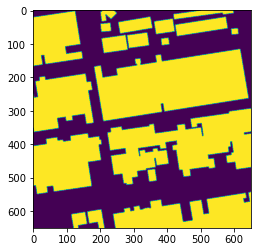

In [8]:
#make sure it worked
%matplotlib inline
plt.imshow(seg_img)

In [9]:
#create interior/exterior segmentation
start = time.perf_counter()
dist_img = dist_map(seg_img)
print(time.perf_counter() - start,"seconds")
print(dist_img.shape, np.min(dist_img), np.max(dist_img), np.unique(dist_img)) 

222.5998126 seconds
(650, 650) -101.71037311896953 84.00602387778854 [-101.71037312 -101.59724406 -101.49384218 ...   83.46211251   83.85529555
   84.00602388]


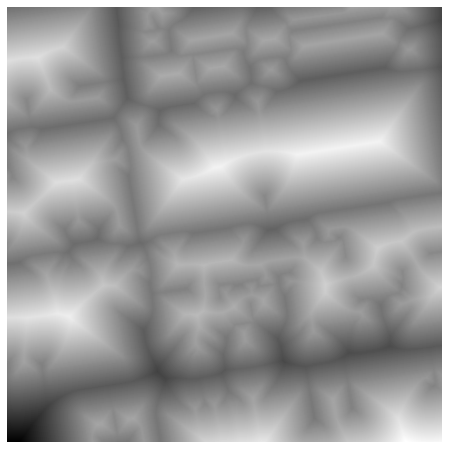

In [11]:
#make sure it worked
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(dist_img, cmap='gray')

In [10]:
#Alternative distance function with breadth first search 
#took 21 minutes for a single image!!! 
"""
def get_distance(img,point): 
    #does a bfs to return the raster pixel distance (int) to the nearest border point (pixelval==1)
    
    width,height=img.shape 
    
    y, x = point
    
    deltas = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)] #all eight directions
    bfs = [(y,x,0)]  #keep track of how far your bfs has traveled 
    traveled = set() 
    while bfs: 
        y, x, distance = bfs.pop(0) #pop from front of list 
        traveled.add((y,x))
        
        #move one step in each direction and check if you can touch a border 
        for dy, dx in deltas: 
            row = y + dy
            col = x + dx 
            if (row,col) not in traveled: #if this is a new point 
                if (row >= 0 and row < height) and (col >=0 and col < width): #if this is a valid point 
                    if img[row,col] == 1: #touching border
                        return distance 
                    else:
                        #add it to the fonteir 
                        bfs.append((row,col,distance+1))"""
    

In [ ]:
def get_output_fn(geojson_fn):
    return 

In [81]:
def save_adj_masks(root, img_ext, geojson_ext, indexes):
    from osgeo import gdal 
    from tqdm import tqdm
    import numpy as np
    import cv2
    import os 
    
    #get a list of items in each of the directories 
    img_dir = os.listdir(root+img_ext)
    img_dir = [file for file, include in zip(img_dir,indexes) if include]
    geojson_dir = os.listdir(root+geojson_ext)
    geojson_dir = [file for file, include in zip(geojson_dir,indexes) if include]


    if len(img_dir) != len(geojson_dir): 
        print(f'Directories don\'t have the same number of files. Check directories: \n{img_dir}\n{geojson_dir}')
        return 
    
    #make output directory in root 
    output_dir = root+"adj_masks/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    done_dir = os.listdir(output_dir)

    for img_fn, json_fn in tqdm(zip(img_dir,geojson_dir)):
        check_output = json_fn[:-8]+".npy"
        if check_output not in done_dir: #if image hasn't already been created 
            #open file 
            lbl_img = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)
            #segment background, border, interior
            seg_img = seg_borders(lbl_img)
            #create distance map 
            dist_img = dist_map(seg_img)
            #save distance map to output directory 
            np.save(output_dir+json_fn[:-8],dist_img)

In [ ]:
#set up slices of distance maps to create 
mask_dir = os.listdir('C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/masks with alt names/') #mask directory 
n = len(mask_dir)
indexes = [False]*n

index1 = indexes.copy()
index2 = indexes.copy()
index3 = indexes.copy()
index4 = indexes.copy()
index5 = indexes.copy()

#set slice to true
index1[:202] = map(lambda x: True, indexes[:202])
index2[202:404] = map(lambda x: True, indexes[202:404])
index3[404:606] = map(lambda x: True, indexes[404:606])
index4[606:808] = map(lambda x: True, indexes[606:808])
index5[808:] = map(lambda x: True, indexes[808:])